## Getting and cleaning data

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import re
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap

%matplotlib inline

#### Rain totals by county

In [2]:
# Import rain data from http://water.weather.gov/precip/download.php.

rain_ds = Dataset('nws_precip_1day_20161108_conus.nc', 'r', \
                       format = 'netCDF4')

rain = rain_ds.variables['observation'][:]

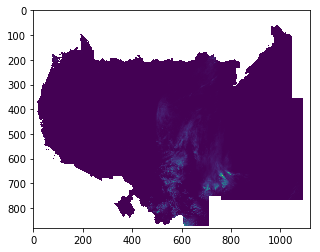

In [3]:
plt.imshow(rain, vmin=0)

In [4]:
rain_x = rain_ds.variables['x'][:]

In [5]:
rain_y = rain_ds.variables['y'][:]

In [6]:
bm = Basemap(width = 1121, height = 881, rsphere = 6371200, \
             projection = 'stere',\
            lat_0 = 90, lon_0 = -105, lat_ts = 60, k_0 = 90)

In [8]:
lats = []
longs = []
totals = []

for i in range(1121):
    for j in range(881):
        if rain.mask[j,i] == False:
            lon, lat = bm(rain_x[i], rain_y[j], inverse = True)
            lats.append(lat)
            longs.append(lon)
            totals.append(rain[j, i])

rain_df = pd.DataFrame({'lat' : lats, 'lon' : longs, \
                           'rain' : totals})

In [99]:
# Print all lat/long pairs to a file so we can look up 
# the county each station is in.

g = int(len(lats)/20)
for m in range(21):
    temp_file = open('lat_longs4_' + str(m) + '.txt', 'w')
    for k in range(m*g, min((m+1)*g, len(lats))):
        temp_file.write("%s, %s\n" % (lats[k], longs[k]))

    temp_file.close()

In [ ]:
# Look up counties at datasciencetoolkit.org. Then reimport the csv files 0-20.

In [9]:
lat_lon_county_df = pd.read_csv('lat_longs4_0.txt.csv')

for m in range(1,20):
    temp = pd.read_csv('lat_longs4_' + str(m) + '.txt.csv')
    lat_lon_county_df = lat_lon_county_df.append(temp)    

In [10]:
lat_lon_county_df = lat_lon_county_df\
                        [lat_lon_county_df['friendly_type'] == 'county']

In [11]:
county_rain = rain_df.merge(lat_lon_county_df, how = 'left', \
                  left_on = ['lat', 'lon'], \
                  right_on = ['latitude', 'longitude'])\
                [['lat', 'lon', 'name', 'code', 'rain']]

In [12]:
rain_by_county = county_rain.groupby('code')['rain'].\
                                                median().to_frame()

#### County demographics and vote totals

In [13]:
# County demographics pulled from 
# https://www.kaggle.com/benhamner/2016-us-election/data

col_names = ['fips', 'area', 'state', '2014 Pop (est.)', \
             '2010 Pop (April 1 estimates base)', 'Pop % Change', \
             '2010 Pop', '% under 5', '% under 18', '% over 65', \
             '% female', '% white', '% black', '% native', '% asian', \
             '% pac. isl.', '% mixed race', '% latino', \
             '% non-hisp. white', '% same house > 1 year', \
             '% foreign-born', '% ESL', '% HS+', '% College+', 'vets',\
             'mean commute time', 'housing units', 'Homeownership rate',\
             '% multi-unit housing', 'median home value', 'households',\
             'persons per household', 'per capita income', \
             'median household income', '% below poverty level',\
             'private non-farm est.', 'private non-farm employment',\
             'private non-farm employment %change', 'non-employer est.',\
             'total firms', '% black-owned firms', '% native-owned firms',\
             '% asian-owned firms', '% pac. isl.-owned firms', \
             'latino-owned firms', \
             '% women-owned firms', 'manufacturers shipments', \
             'merchant wholesaler sales', 'retail sales ($1000)', \
             'retail sales per capita', 'hotel & dining sales ($1000)', \
             'building permits', 'land area (sq. mi.)', 'density']

demo_df = pd.read_csv('county_demographics.csv', header = 0,\
                                                  names = col_names)

In [14]:
# County-level vote totals pulled from 
# https://github.com/tonmcg/County_Level_Election_Results_12-16

vote_col_names = ['Clinton', 'Trump', 'Total', '%Clinton', '%Trump',\
                 'diff', 'points_diff', 'state', 'county', 'fips']

votes_df = pd.read_csv('county_vote_totals.csv', skiprows = 29, \
                      names = ['junk'] + vote_col_names)[vote_col_names]

In [15]:
# County-level results for both '12 and '16, again pulled from
# https://github.com/tonmcg/County_Level_Election_Results_12-16
# Note that there is no data for Alaska in this version.

vote_1216_col_names = ['fips_int', 'Dem votes 16', 'GOP votes 16', 'total votes 16',\
                      '% Dem 16', '% GOP 16', 'diff 16', 'points diff 16', 'state',\
                      'county', 'fips', 'total votes 12', 'Dem votes 12', 'GOP votes 12',\
                      'county fips', 'state fips', '% Dem 12', '% GOP 12', 'diff 12',\
                      'points diff 12']

votes_1216_df = pd.read_csv('county_vote_totals_12-16.csv', skiprows = 30, header = None, \
            names = ['junk1'] + vote_1216_col_names)[vote_1216_col_names]

In [16]:
votes_df.at[0, 'county'] = 'Alaska'
votes_df.at[0, 'fips'] = 2000

In [17]:
df = votes_df.merge(demo_df, how = 'left', left_on = 'fips', \
                                                    right_on = 'fips')
df_1216 = votes_1216_df.merge(demo_df, how = 'left', \
                            left_on = 'fips_int', right_on = 'fips')

In [18]:
del df['state_x']
del df_1216['state_x']

In [19]:
df = df.rename(columns = {'state_y' : 'state'})
df_1216 = df_1216.rename(columns = {'state_y' : 'state'})

In [20]:
def fix_fips(integer):
    fips = str(integer)
    if len(fips) < 5:
        fips = '0' + fips
    fips = fips[:2] + '_' + fips[2:]
    return fips

df['fips'] = df['fips'].apply(fix_fips)

In [21]:
df_1216['good_fips'] = df_1216['fips_int'].apply(fix_fips)

In [24]:
# Combine voting results with rainfall data.

full_df = df.merge(rain_by_county, how = 'left', left_on = 'fips', \
                                               right_index = True)

In [25]:
full_1216_df = df_1216.merge(rain_by_county, how = 'left', \
                             left_on = 'good_fips', right_index = True)

####  Introducing some features

In [26]:
# Group states together into regions. I tried to do so in such a way
# that there was some degree of political uniformity within regions.
# A more formal clustering analysis might be an interesting future project.

region_dict = dict.fromkeys(['MA', 'ME', 'CT', 'RI', \
                            'NH', 'VT'], 'New England')
region_dict.update(dict.fromkeys(['NJ', 'NY', 'PA', 'MD', 'DE', 'DC', 'VA'], 
                                                 'Mid-Atlantic'))
region_dict.update(dict.fromkeys(['OH', 'IL', 'IN', 'MI', 'WI', 'MN'],\
                                 'Midwest'))
region_dict.update(dict.fromkeys(['NE', 'IA', 'KS', 'MO', 'OK'], \
                                'Heartland'))
region_dict.update(dict.fromkeys(['MT', 'ID', 'WY', 'ND', 'SD', 'UT'], \
                                                             'Mountain'))
region_dict.update(dict.fromkeys(['NV', 'AZ', 'NM', 'CO'], \
                                                             'Southwest'))
region_dict.update(dict.fromkeys(['WV', 'KY', 'TN', 'NC',\
                                 'SC', 'GA', 'AL', 'MS', 'FL', 'AR',\
                                 'LA', 'TX'], 'Deep South'))
region_dict.update(dict.fromkeys(['CA', 'OR', 'WA'], 'West Coast'))
region_dict.update(dict.fromkeys(['AK'], 'Alaska'))
region_dict.update(dict.fromkeys(['HI'], 'Hawaii'))
region_dict[np.nan] = np.nan

full_df['region'] = full_df['state'].apply(lambda x : region_dict[x])
full_1216_df['region'] = full_1216_df['state'].\
                                apply(lambda x : region_dict[x])

In [27]:
# Making a copy of the region column so that when we get dummies,
# we'll still have the original.

full_1216_df['region_for_dummies'] = full_1216_df['region']

In [28]:
full_1216_df = pd.get_dummies(full_1216_df, \
        columns = ['region_for_dummies'], prefix = '', prefix_sep = '')

In [58]:
# Introduce columns for changes from 2012 results to 2016 results.

full_1216_df['points margin change'] = \
    100*(full_1216_df['points diff 16'] - full_1216_df['points diff 12'])

full_1216_df['points Dem change'] = \
    100*(full_1216_df['% Dem 16'] - full_1216_df['% Dem 12'])

full_1216_df['points GOP change'] = \
    100*(full_1216_df['% GOP 16'] - full_1216_df['% GOP 12'])
    
full_1216_df['Dem votes change'] = \
    100*(full_1216_df['Dem votes 16'] - full_1216_df['Dem votes 12'])
    
full_1216_df['GOP votes change'] = \
    100*(full_1216_df['GOP votes 16'] - full_1216_df['GOP votes 12'])
    
full_1216_df['GOP votes change factor'] = \
    (full_1216_df['GOP votes 16']/full_1216_df['GOP votes 12'])
    
full_1216_df['Dem votes change factor'] = \
    (full_1216_df['Dem votes 16']/full_1216_df['Dem votes 12'])

In [30]:
full_df.columns

Index(['Clinton', 'Trump', 'Total', '%Clinton', '%Trump', 'diff',
       'points_diff', 'county', 'fips', 'area', 'state', '2014 Pop (est.)',
       '2010 Pop (April 1 estimates base)', 'Pop % Change', '2010 Pop',
       '% under 5', '% under 18', '% over 65', '% female', '% white',
       '% black', '% native', '% asian', '% pac. isl.', '% mixed race',
       '% latino', '% non-hisp. white', '% same house > 1 year',
       '% foreign-born', '% ESL', '% HS+', '% College+', 'vets',
       'mean commute time', 'housing units', 'Homeownership rate',
       '% multi-unit housing', 'median home value', 'households',
       'persons per household', 'per capita income', 'median household income',
       '% below poverty level', 'private non-farm est.',
       'private non-farm employment', 'private non-farm employment %change',
       'non-employer est.', 'total firms', '% black-owned firms',
       '% native-owned firms', '% asian-owned firms',
       '% pac. isl.-owned firms', 'latino-owned

In [31]:
# Also add a column for the 2016 winner

def winner(row):
    if row['Clinton'] > row['Trump']:
        return 'Clinton'
    else:
        return 'Trump'

full_df['winner'] = full_df.apply(winner, axis = 1)

def winner_16(row):
    if row['Dem votes 16'] > row['GOP votes 16']:
        return 'Clinton'
    else:
        return 'Trump'

full_1216_df['winner'] = full_1216_df.apply(winner_16, axis = 1)

## Exploratory analysis: finding correlations and patterns

In [33]:
# Quick observation: median blue county population grew by 1.4% 2010-2014. 
# Median red county showed population decline.

full_df.groupby('winner')['Pop % Change'].describe()

,count,mean,std,min,25%,50%,75%,max
winner,,,,,,,,
Clinton,487.0,1.639836,4.413524,-10.8,-1.25,1.4,4.55,18.0
Trump,2626.0,0.230807,4.116897,-17.0,-2.00,-0.5,1.70,72.9


In [43]:
# Take a peak at those counties swinging hardest toward Dems.

full_1216_df.sort_values('points Dem change', ascending = False)\
                        [['% Dem 16', '% GOP 16',  \
                        '% Dem 12', '% GOP 12', 'points Dem change', \
                        '% non-hisp. white', '% College+', 'density', \
                        'median household income', 'state']].head()

,% Dem 16,% GOP 16,% Dem 12,% GOP 12,points Dem change,% non-hisp. white,% College+,density,median household income,state
2677,0.300923,0.678141,0.207466,0.787819,9.345702,35.9,16.2,11.7,44943,TX
2783,0.769867,0.168882,0.692178,0.293599,7.768846,62.8,71.7,7993.6,103208,VA
2815,0.757793,0.172558,0.691055,0.295555,6.673847,72.3,74.4,6169.1,120000,VA
2845,0.618464,0.312908,0.554352,0.428091,6.411217,81.1,41.7,2820.2,36505,VA
424,0.509562,0.452143,0.446200,0.539867,6.336179,40.6,33.9,1871.2,60445,GA


In [44]:
# And those swinging hardest toward the GOP.

full_1216_df.sort_values('points GOP change', ascending = False)[['% Dem 16', '% GOP 16',  \
                        '% Dem 12', '% GOP 12', 'points GOP change', \
                        '% non-hisp. white', '% College+', 'density', \
                        'median household income', 'state']].head()

,% Dem 16,% GOP 16,% Dem 12,% GOP 12,points GOP change,% non-hisp. white,% College+,density,median household income,state
994,0.259923,0.702494,0.494373,0.469362,23.313162,94.6,7.7,33.5,24246,KY
1393,0.218335,0.741255,0.433488,0.536434,20.482041,97.2,12.0,14.1,40204,MO
565,0.371422,0.579321,0.598270,0.387676,19.164538,96.5,11.6,20.2,46429,IA
2068,0.246336,0.715076,0.445944,0.524989,19.008740,97.5,10.4,32.1,40573,OH
1460,0.178100,0.792216,0.361389,0.602941,18.927518,94.6,6.7,8.3,34496,MO


In [40]:
# One is struck by the shear size of the swings in this latter table. 
# We also notice that every one of the top five is over 94% white, and all
# are below the medians for '% College+' and 'density.' They are also all
# below or roughly equal to the median for median household income.

print('median % college+:', full_1216_df['% College+'].median())
print('median % non-hisp. white:', full_1216_df['% non-hisp. white'].median())
print('median density:', full_1216_df['density'].median())
print('median (median household income):', full_1216_df['median household income'].median())

median % college+: 17.5
median % non-hisp. white: 84.7
median density: 45.7
median (median household income): 44101.5


It is worth noting an interesting quirk of this election. If 
instead of looking at the biggest Dem gains, we look at the biggest
shift in the Dem-GOP margin, one might expect similar results, but instead we have
the following.

In [45]:
full_1216_df.sort_values('points margin change', ascending = False)\
                        [['% Dem 16', '% GOP 16',  \
                        '% Dem 12', '% GOP 12', 'points margin change', \
                        '% non-hisp. white', '% College+', 'density', \
                        'median household income', 'state']].head()

,% Dem 16,% GOP 16,% Dem 12,% GOP 12,points margin change,% non-hisp. white,% College+,density,median household income,state
2771,0.140498,0.513056,0.097912,0.882557,41.208738,83.3,36.5,257.8,60196,UT
2749,0.186878,0.463865,0.146473,0.830696,40.723676,84.2,36.9,96.7,49506,UT
2752,0.215696,0.448926,0.181375,0.799783,38.517924,84.7,34.1,1025.8,69707,UT
652,0.076560,0.569962,0.057730,0.932903,38.177129,89.4,33.7,80.0,32059,ID
2761,0.111371,0.614486,0.088330,0.894737,30.329206,95.3,33.4,15.5,80337,UT


This is of course "the McMullin effect." Many conservative votes in Mormon areas fled to independent candidate Evan McMullin, decreasing GOP vote share without increase Democrats' performance.

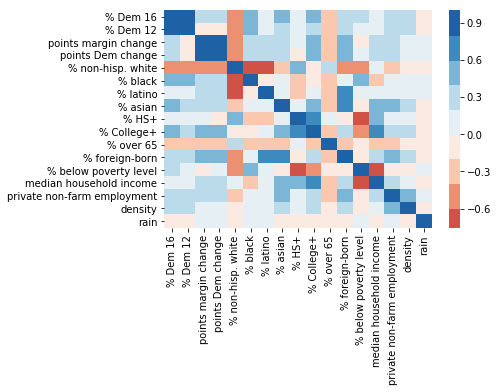

In [46]:
# Let's see how some of the most pertinent columns are correlated.

feat_set = ['% Dem 16', '% Dem 12', 'points margin change', 'points Dem change', \
             '% non-hisp. white', '% black', '% latino', '% asian', \
             '% HS+', '% College+', '% over 65', '% foreign-born', \
             '% below poverty level', \
             'median household income', 'private non-farm employment', \
             'density', 'rain']

sns.heatmap(full_1216_df[feat_set].corr(), \
                        cmap = sns.color_palette("RdBu", 10), center = 0)

In [246]:
# Below we can see the statistics most correlated with a swing one way or the other
# from 2012 to 2016 (positive number correspond to a shift toward Dems; negative numbers
# represent a shift toward the GOP).

feat_set2 = ['points margin change', 'Pop % Change'] + col_names[7:]

corr = full_1216_df[feat_set2].corr()
corr['marg_change_abs'] = corr['points margin change'].apply(lambda x : abs(x))

corr.iloc[1:].sort_values('marg_change_abs', ascending = False)['points margin change']

% College+                             0.539874
% foreign-born                         0.489554
% non-hisp. white                     -0.438424
median home value                      0.436166
% ESL                                  0.383832
Pop % Change                           0.378978
% asian                                0.369612
% over 65                             -0.363280
persons per household                  0.348681
Homeownership rate                    -0.344630
% multi-unit housing                   0.340295
median household income                0.336451
% latino                               0.330493
building permits                       0.319824
vets                                   0.317562
% asian-owned firms                    0.308805
retail sales ($1000)                   0.303453
housing units                          0.293935
per capita income                      0.293929
households                             0.292814
private non-farm est.                  0

There is a subtely to be careful with here. We see that "% white" is correlated with a shift toward the Republican candidate, while "% black" is correlated with a shift toward the Democratic candidate, but in fact the margin among black voters actually decreased from '12 to '16, while the margin among whites barely changed. (See for example http://www.pewresearch.org/fact-tank/2016/11/09/behind-trumps-victory-divisions-by-race-gender-education/.) So what is going on?

We have to keep in mind that these are results by county. So the correlation with "% white" listed above isn't about white voters per se, but rather voters living in disproportionately white districts. The same is true for "% black." One can imagine, for example, that white voters living in counties with large black populations might be less inclined to vote for Trump than Romney, even as their black neighbors were less enthusiastic about Clinton than they were about the first black president.

### Did rain hurt one candidate more than the other?

In the heatmap above 2016 rainfall is negatively correlated
with both Obama and Clinton vote share, but positively correlated with
the Dem - GOP point margin change from '12 to '16. Roughly speaking,
this suggests that counties experiencing more rain tended to be red 
and their shift from 2012-2016 was more Dem-friendly than typical.
These correlations are very weak however. 
Let's look at it in a different way.

/Users/ryan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=15,center=False).mean()
  
/Users/ryan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=15,center=False).mean()
  import sys


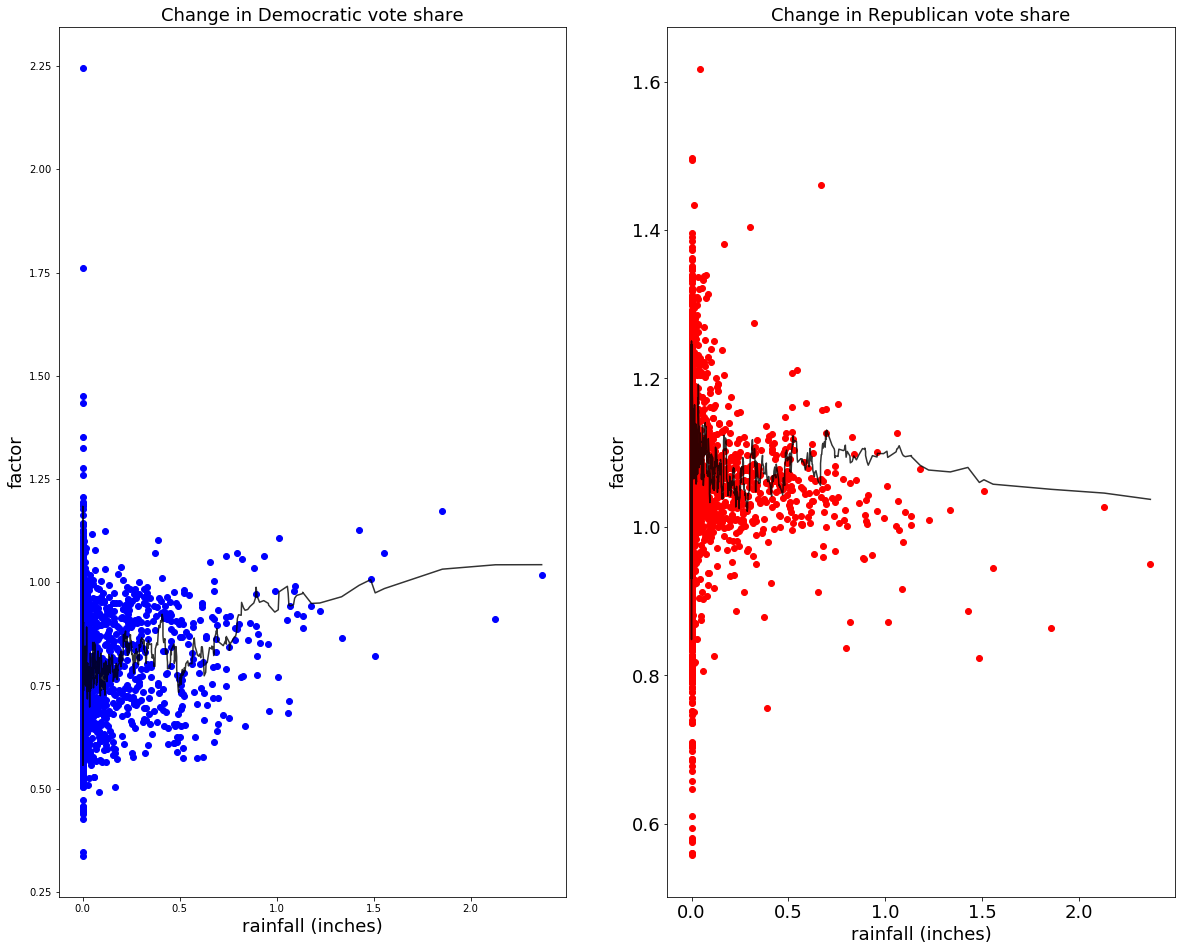

In [100]:
# Looking at the factor by which each party's vote share changed in each county,
# there doesn't seem to be much relation to rainfall. What little effect there may be appears
# to favor Clinton. This lines up with the correlations we found.

plt.figure(figsize = (20,16))
y1 = pd.rolling_mean(full_1216_df.sort_values(by = 'rain')\
                ['Dem votes change factor'], 15)
y2 = pd.rolling_mean(full_1216_df.sort_values(by = 'rain')\
                ['GOP votes change factor'], 15)
x = full_1216_df.sort_values(by = 'rain')['rain']
rain_fontsize = 18

plt.subplot(1, 2, 1)
plt.scatter(full_1216_df['rain'], full_1216_df['% Dem 16']/full_1216_df['% Dem 12'], \
                                                                            color = 'blue')
plt.plot(x, y1, color = 'black', alpha = .8)
plt.xlabel('rainfall (inches)', fontsize = rain_fontsize)
plt.ylabel('factor', fontsize = rain_fontsize)
plt.title('Change in Democratic vote share', fontsize = rain_fontsize)

plt.subplot(1, 2, 2)
plt.scatter(full_1216_df['rain'], full_1216_df['% GOP 16']/full_1216_df['% GOP 12'],\
                                                                           color = 'red')
plt.plot(x, y2, color = 'black', alpha = .8)
plt.xlabel('rainfall (inches)', fontsize = rain_fontsize)
plt.ylabel('factor', fontsize = rain_fontsize)
plt.title('Change in Republican vote share', fontsize = rain_fontsize)
plt.gca().tick_params('both', labelsize = 18)

In [73]:
# We can also simply sum up how many more, or fewer, votes each candidate got in 
# counties with and without any rain. In the above a county with a huge population
# count as a single data point, the same as a county with a tiny population.

rep_dry_change = full_1216_df[full_1216_df['rain'] == 0]['GOP votes 16'].sum() - \
                                full_1216_df[full_1216_df['rain'] == 0]['GOP votes 12'].sum()
print('GOP vote change in counties without 2016 rainfall:', rep_dry_change)
rep_rainy_change = full_1216_df[full_1216_df['rain'] > 0]['GOP votes 16'].sum() - \
                                full_1216_df[full_1216_df['rain'] > 0]['GOP votes 12'].sum()
print('GOP vote change in counties with 2016 rainfall:', rep_rainy_change)
dem_dry_change = full_1216_df[full_1216_df['rain'] == 0]['Dem votes 16'].sum() - \
                                full_1216_df[full_1216_df['rain'] == 0]['Dem votes 12'].sum()
print('Dem vote change in counties without 2016 rainfall:', dem_dry_change)
dem_rainy_change = full_1216_df[full_1216_df['rain'] > 0]['Dem votes 16'].sum() - \
                                full_1216_df[full_1216_df['rain'] > 0]['Dem votes 12'].sum()
print('Dem vote change in counties with 2016 rainfall:', dem_rainy_change)
print()
dry_pop = full_1216_df[full_1216_df['rain'] == 0]['2014 Pop (est.)'].sum()
print('Total population of counties without 2016 rainfall:', dry_pop)
rainy_pop = full_1216_df[full_1216_df['rain'] > 0]['2014 Pop (est.)'].sum()
print('Total population of counties with 2016 rainfall:', rainy_pop)
print()
print('GOP votes per person change in dry counties:', rep_dry_change/dry_pop)
print('GOP votes per person change in rainy counties:', rep_rainy_change/rainy_pop)
print('Dem votes per person change in dry counties:', dem_dry_change/dry_pop)
print('Dem votes per person change in rainy counties:', dem_rainy_change/rainy_pop)

GOP vote change in counties without 2016 rainfall: 1944810.0
GOP vote change in counties with 2016 rainfall: 326245.0
Dem vote change in counties without 2016 rainfall: 337179.0
Dem vote change in counties with 2016 rainfall: -85275.0

Total population of counties without 2016 rainfall: 254154106
Total population of counties with 2016 rainfall: 62383194

GOP votes per person change in dry counties: 0.00765208963415
GOP votes per person change in rainy counties: 0.00522969375374
Dem votes per person change in dry counties: 0.00132667146444
Dem votes per person change in rainy counties: -0.00136695469616


This tells a slightly different story. Democrats modestly gained votes in aggregate in non-rainy counties, but lost votes in rainy ones. Republicans gained a lot of votes in dry counties and gained modestly in rainy ones. Adjusting for population shows that both candidates did about .0025 votes per person worse in rainy ones compared to dry ones, with Clinton underperforming a bit more than Trump in rainy districts. As above though, these effects are miniscule. 

In [77]:
# One last observation: even the minor effects above are largely moot, because no competitive 
# state experienced more than 3 inches of rainfall statewide. However, looking at the impact in
# Wisconsin and Michigan specifically is probably worthwhile given the razor-thin margins in
# those states. I hope to update this notebook later with an exploration of those.

full_1216_df.groupby('state')['rain'].sum().sort_values(ascending = False)[:17]

state
TX    49.763779
LA    31.354331
MS    22.383858
OK    21.531496
MO    15.047244
NE    14.970473
AR    12.029528
KS    11.931102
WI     2.525591
TN     2.173228
MI     1.482283
WA     1.023622
IL     0.905512
IA     0.836614
SD     0.503937
KY     0.283465
AL     0.232283
Name: rain, dtype: float64

### A closer look at some of the most relevant features.

/Users/ryan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50,center=False).mean()
  """
/Users/ryan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50,center=False).mean()
  import sys


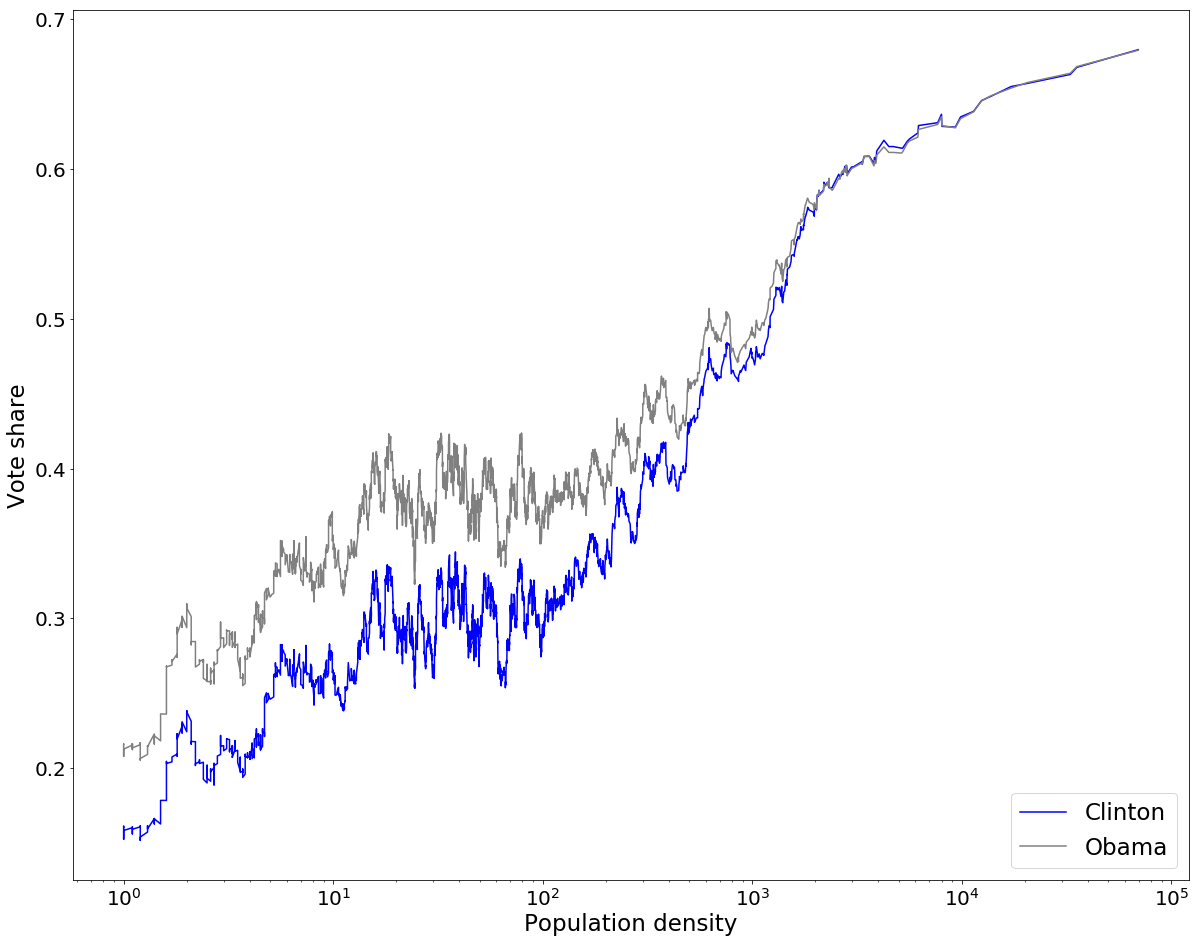

In [136]:
# Obama's 2012 support came disproportionately from densely populated areas; 
# Clinton's 2016 support even more so.

plt.figure(figsize=(20, 16))
y1 = pd.rolling_mean(full_1216_df.sort_values(by = 'density')['% Dem 16'], 50)
x = full_1216_df.sort_values(by = 'density')['density']
y2 = pd.rolling_mean(full_1216_df.sort_values(by = 'density')['% Dem 12'], 50)
plt.plot(x, y1, color = 'blue', label = 'Clinton')
plt.plot(x, y2, color = 'grey', label = 'Obama')
plt.gca().set_xscale('log')
plt.xlabel('Population density', fontsize = 23)
plt.ylabel('Vote share', fontsize = 23)
plt.legend(loc = 'lower right', fontsize = 23)
plt.gca().tick_params('both', labelsize = 20)
plt.show()

/Users/ryan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=100,center=False).mean()
  """
/Users/ryan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=100,center=False).mean()
  if __name__ == '__main__':


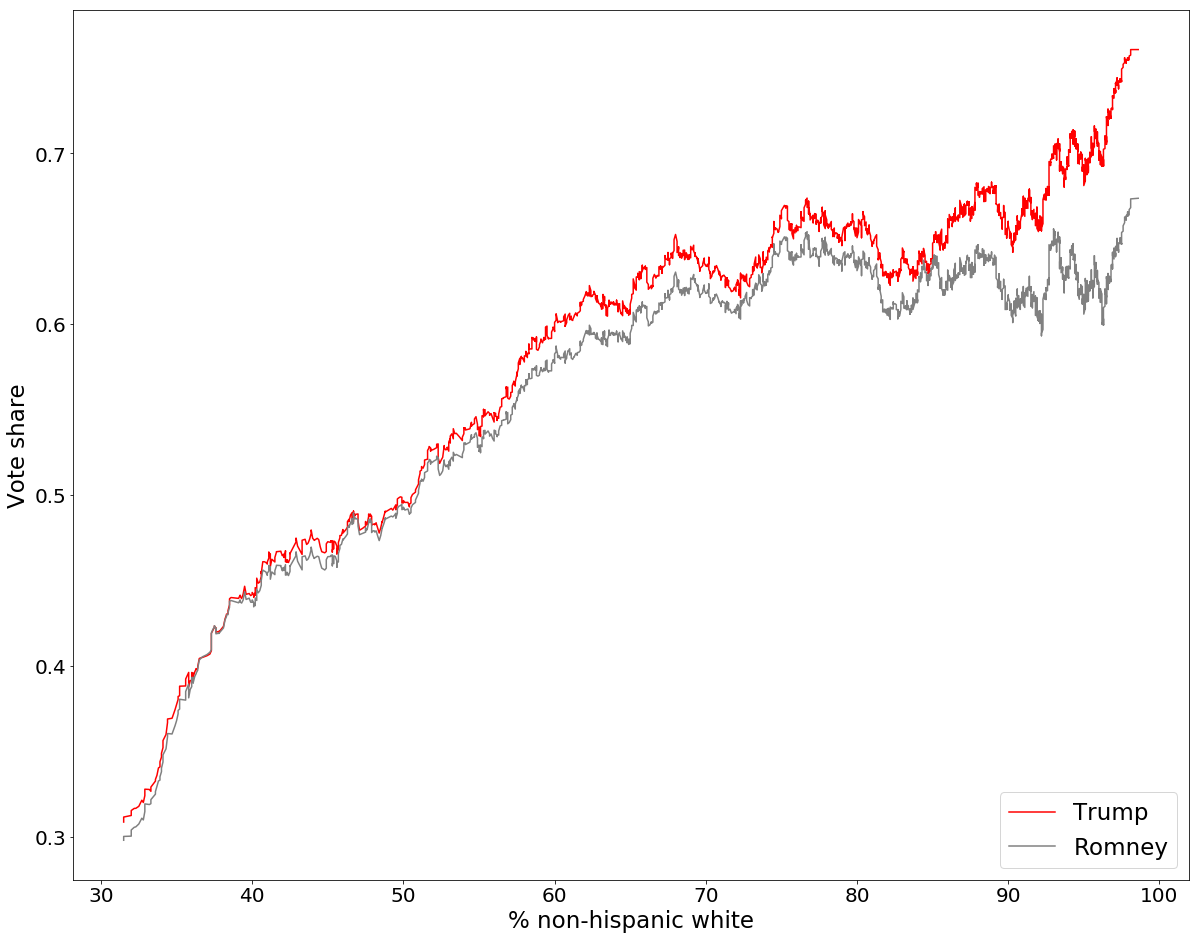

In [139]:
# Counties with a higher proportion of non-hispanic white citizens
# tended 

plt.figure(figsize = (20, 16))
y = pd.rolling_mean(full_1216_df.sort_values(by = '% non-hisp. white')\
                        ['% GOP 16'], 100)
x = full_1216_df.sort_values(by = '% non-hisp. white')['% non-hisp. white']
plt.plot(x, y, color = 'red', label = 'Trump')

y2 = pd.rolling_mean(full_1216_df.sort_values(by = '% non-hisp. white')\
                         ['% GOP 12'], 100)
plt.plot(x, y2, color = 'grey', label = 'Romney')
# plt.gca().set_xscale('log')
plt.xlabel('% non-hispanic white')
plt.ylabel('Vote share')
plt.xlabel('% non-hispanic white', fontsize = 23)
plt.ylabel('Vote share', fontsize = 23)
plt.legend(loc = 'lower right', fontsize = 23)
plt.gca().tick_params('both', labelsize = 20)
plt.show()

Clearly both candidates did better in disproportionately white districts, and the two curves follow each other pretty closely, but the gap between them does seem to widen as we move to the right. Let's look at the change in GOP vote share.

/Users/ryan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=150,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until


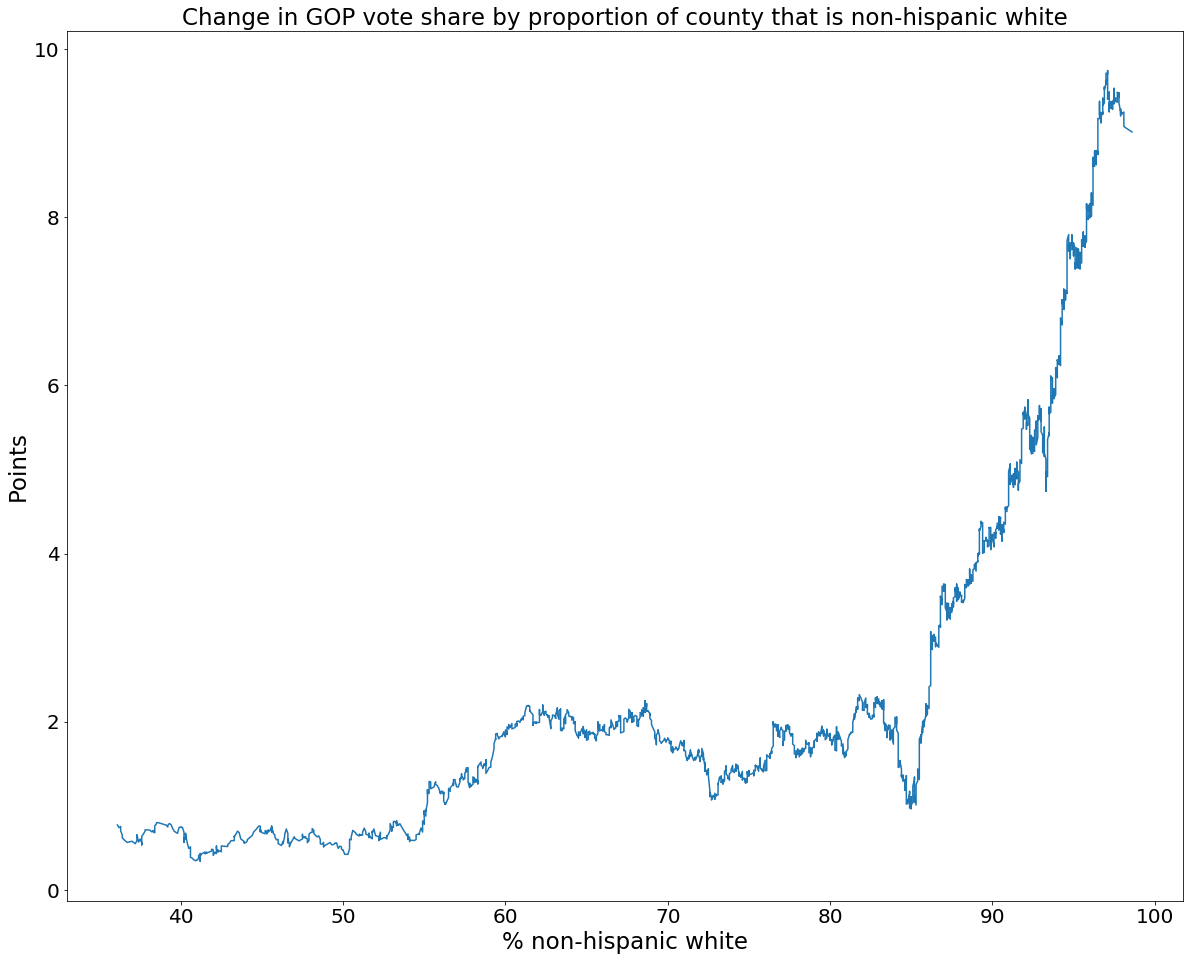

In [96]:
plt.figure(figsize = (20, 16))

y = pd.rolling_mean(full_1216_df.sort_values(by = '% non-hisp. white')\
                ['points GOP change'], 150)
x = full_1216_df.sort_values(by = '% non-hisp. white')['% non-hisp. white']

plt.plot(x,y)

plt.xlabel('% non-hispanic white', fontsize = 23)
plt.ylabel('Points', fontsize = 23)
plt.title('Change in GOP vote share by proportion of county that is non-hispanic white', \
                     fontsize = 23)
plt.gca().tick_params('both', labelsize = 20)

plt.show()

/Users/ryan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=150,center=False).mean()
  """
/Users/ryan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=150,center=False).mean()
  


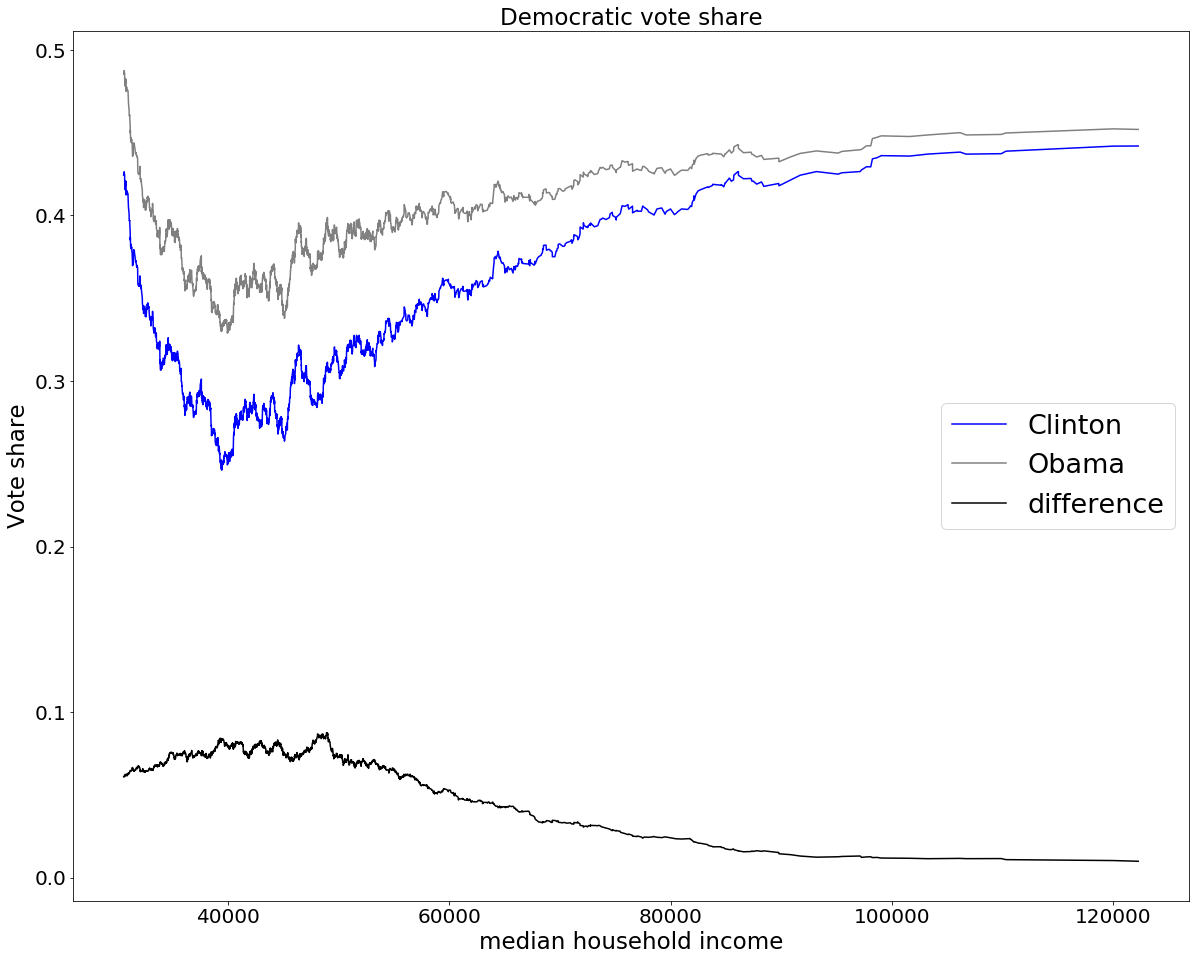

In [125]:
# Let's look at median household income.

plt.figure(figsize = (20,16))

y1 = pd.rolling_mean(full_1216_df.sort_values\
                            (by = 'median household income')['% Dem 16'], 150)
y2 = pd.rolling_mean(full_1216_df.sort_values\
                            (by = 'median household income')['% Dem 12'], 150)

x = full_1216_df.sort_values(by = 'median household income')['median household income']

plt.plot(x, y1, color = 'blue', label = 'Clinton')
plt.plot(x, y2, color = 'grey', label = 'Obama')
plt.plot(x, y2-y1, color = 'black', label = 'difference')

plt.xlabel('median household income', fontsize = 23)
plt.ylabel('Vote share', fontsize = 23)
plt.title('Democratic vote share by median household income', \
                     fontsize = 23)
plt.gca().tick_params('both', labelsize = 20)
plt.legend(loc = 'center right', fontsize = 27)


plt.show()

Clinton did about as well as Obama in upper-middle and upper class counties, but underperformed in areas with median household income around or below the national median.
A good next step would be to try to separate this effect from obvious correlates like race, college education, and population density. As a simple first step, it is interesting to restrict ourselves to counties where the proportion of non-hispanic whites is above the national median.

/Users/ryan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=150,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ryan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=150,center=False).mean()
  after removing the cwd from sys.path.


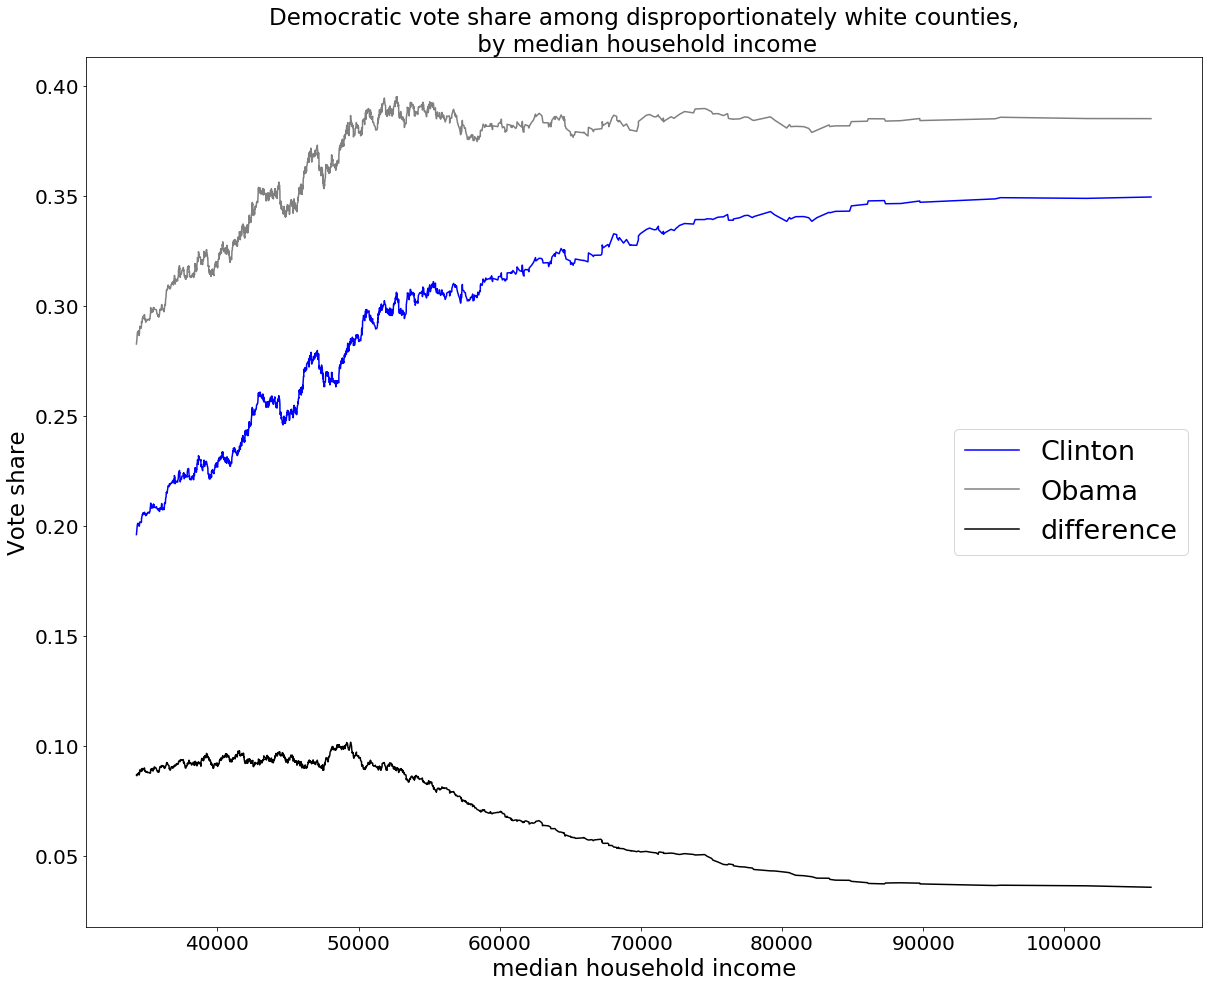

In [129]:
plt.figure(figsize = (20,16))

y1 = pd.rolling_mean(full_1216_df[full_1216_df['% non-hisp. white'] > 77].sort_values\
                            (by = 'median household income')['% Dem 16'], 150)
y2 = pd.rolling_mean(full_1216_df[full_1216_df['% non-hisp. white'] > 77].sort_values\
                            (by = 'median household income')['% Dem 12'], 150)

x = full_1216_df[full_1216_df['% non-hisp. white'] > 77].sort_values\
                    (by = 'median household income')['median household income']

plt.plot(x, y1, color = 'blue', label = 'Clinton')
plt.plot(x, y2, color = 'grey', label = 'Obama')
plt.plot(x, y2-y1, color = 'black', label = 'difference')

plt.xlabel('median household income', fontsize = 23)
plt.ylabel('Vote share', fontsize = 23)
plt.title('Democratic vote share among disproportionately white counties,\n \
by median household income', fontsize = 23)
plt.gca().tick_params('both', labelsize = 20)
plt.legend(loc = 'center right', fontsize = 27)


plt.show()

The difference curve looks similar, but notice the lack of the "dip" in the two other curves. Democrats' strong performance in low-income counties is largely due to the racial make-up of those counties.

/Users/ryan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=100,center=False).mean()
  """
/Users/ryan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=100,center=False).mean()
  import sys


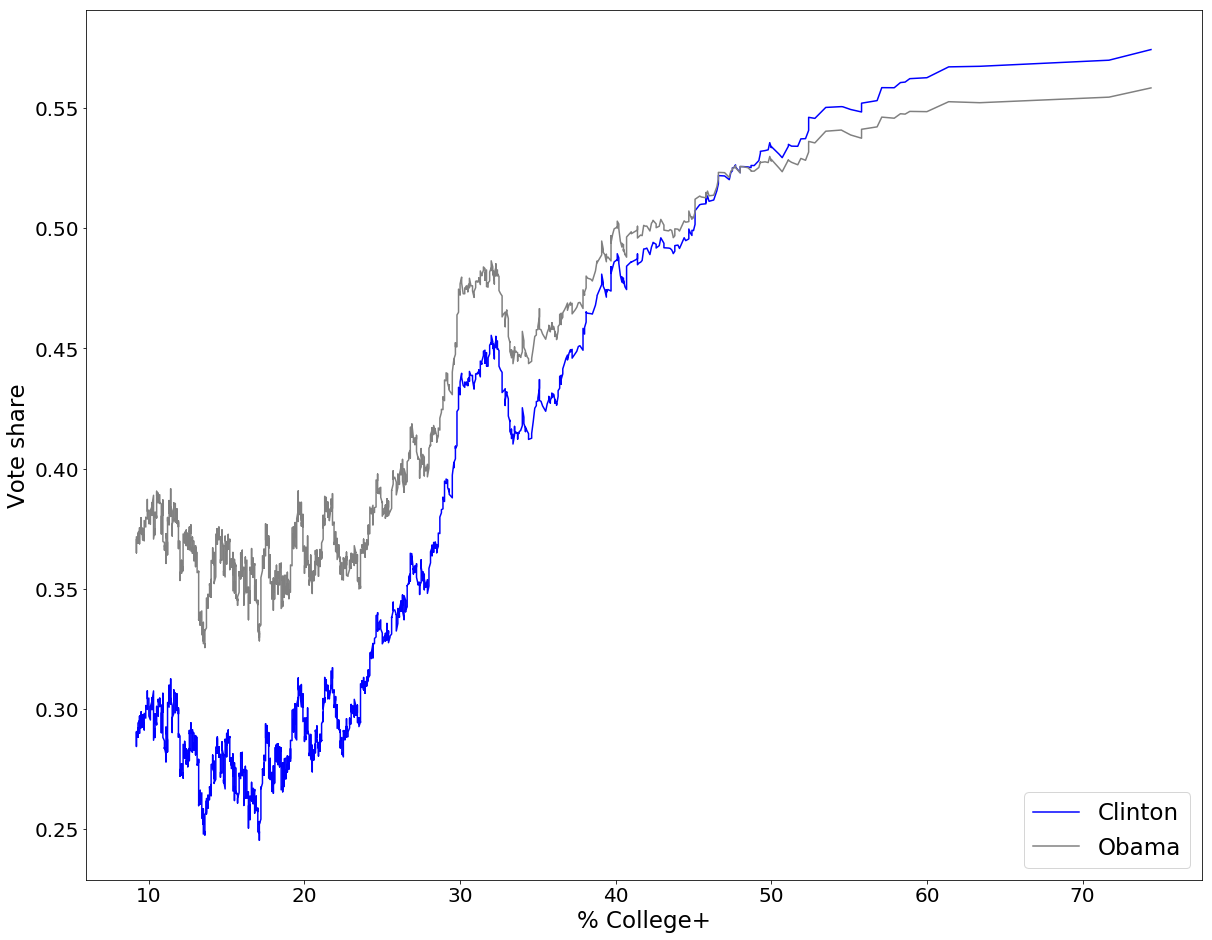

In [140]:
# Clinton did even better than Obama in counties with many college graduates, 
# but much worse than him in places with relatively few college graduates.

plt.figure(figsize=(20, 16))
y1 = pd.rolling_mean(full_1216_df.sort_values(by = '% College+')['% Dem 16'], 100)
x = full_1216_df.sort_values(by = '% College+')['% College+']
y2 = pd.rolling_mean(full_1216_df.sort_values(by = '% College+')['% Dem 12'], 100)
plt.plot(x, y1, color = 'blue', label = 'Clinton')
plt.plot(x, y2, color = 'grey', label = 'Obama')
plt.xlabel('% College+', fontsize = 23)
plt.ylabel('Vote share', fontsize = 23)
plt.legend(loc = 'lower right', fontsize = 23)
plt.gca().tick_params('both', labelsize = 20)
plt.show()

/Users/ryan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=100,center=False).mean()
  
/Users/ryan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=100,center=False).mean()
  after removing the cwd from sys.path.


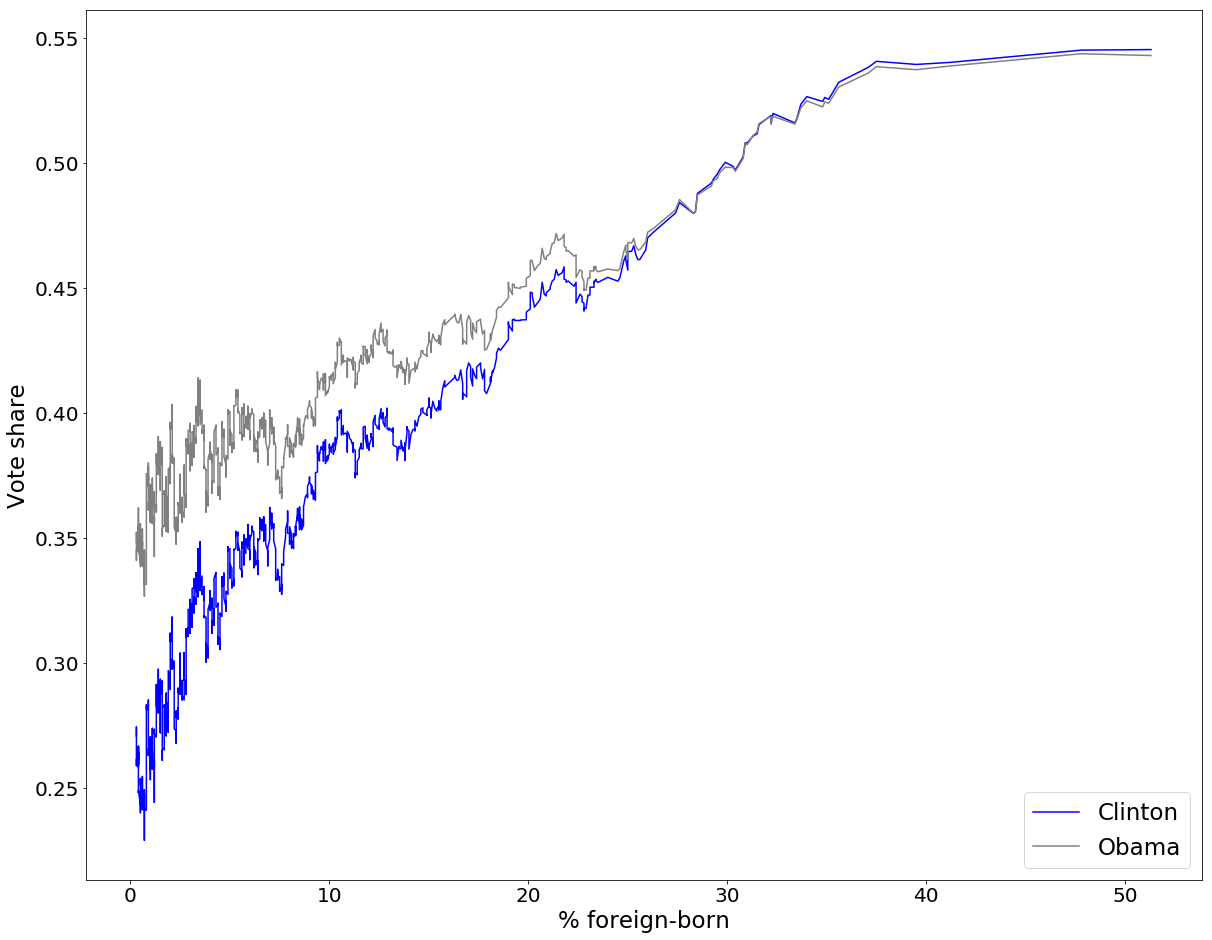

In [142]:
plt.figure(figsize=(20, 16))
y1 = pd.rolling_mean(full_1216_df.sort_values(by = '% foreign-born')['% Dem 16'], 100)
x = full_1216_df.sort_values(by = '% foreign-born')['% foreign-born']
y2 = pd.rolling_mean(full_1216_df.sort_values(by = '% foreign-born')['% Dem 12'], 100)
plt.plot(x, y1, color = 'blue', label = 'Clinton')
plt.plot(x, y2, color = 'grey', label = 'Obama')
plt.xlabel('% foreign-born', fontsize = 23)
plt.ylabel('Vote share', fontsize = 23)
plt.legend(loc = 'lower right', fontsize = 23)
plt.gca().tick_params('both', labelsize = 20)
plt.show()

# How much does region matter?

In [143]:
full_1216_df.groupby('region')['% Dem 16'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
Deep South,1184.0,0.309469,0.157170,0.031447,0.198240,0.267000,0.387040,0.864732
Hawaii,4.0,0.630066,0.012988,0.614786,0.622350,0.630466,0.638181,0.644546
Heartland,489.0,0.230866,0.103942,0.046154,0.159346,0.211507,0.282285,0.796582
Mid-Atlantic,311.0,0.407235,0.160317,0.134065,0.288931,0.381334,0.490996,0.928466
Midwest,524.0,0.330242,0.104243,0.126938,0.254821,0.312267,0.385329,0.784206
Mountain,271.0,0.236985,0.127315,0.047552,0.150319,0.206245,0.288538,0.864641
New England,67.0,0.526252,0.097443,0.338801,0.461696,0.513767,0.585584,0.794723
Southwest,129.0,0.369248,0.163499,0.086651,0.242963,0.341207,0.492836,0.751691
West Coast,133.0,0.437019,0.154850,0.164657,0.326794,0.411875,0.531598,0.855317


/Users/ryan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50,center=False).mean()
  after removing the cwd from sys.path.


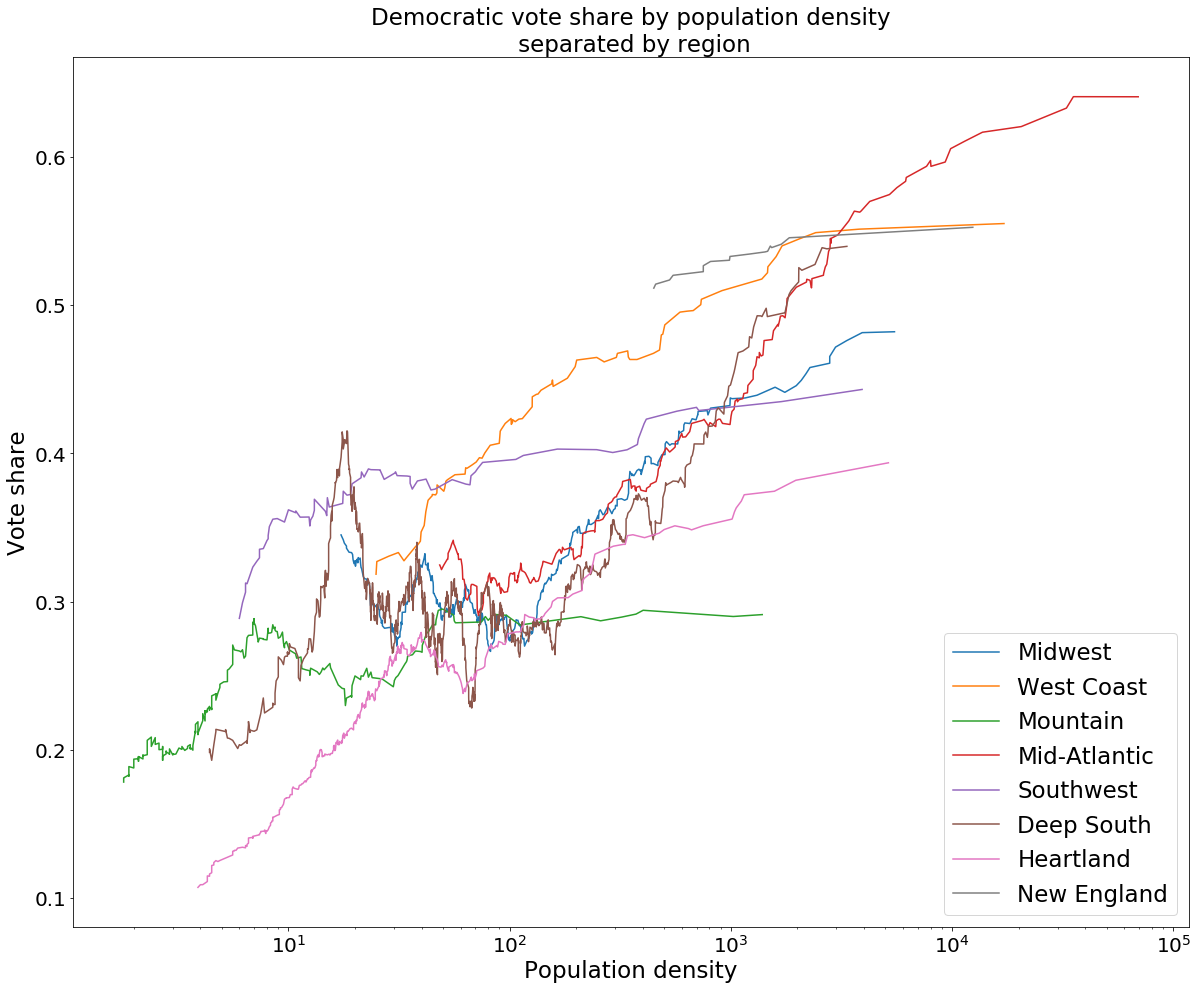

In [146]:
den_by_reg = {}
plt.figure(figsize=(20, 16))
for region in set(region_dict.values()) - {np.nan, 'Hawaii', 'Alaska'}:
    den_by_reg[region] = (full_1216_df[full_1216_df['region'] == region].\
                sort_values(by = 'density')['density'],\
                    pd.rolling_mean(full_1216_df\
                        [full_1216_df['region'] == region].\
                            sort_values(by = 'density')['% Dem 16'], 50))
for region in set(region_dict.values()) - {np.nan, 'Hawaii', 'Alaska'}:
    plt.plot(den_by_reg[region][0], den_by_reg[region][1], label = region)
plt.legend(loc = 'lower right', fontsize = 23)
plt.gca().set_xscale('log')
plt.xlabel('Population density', fontsize = 23)
plt.ylabel('Vote share', fontsize = 23)
plt.title('Democratic vote share by population density\n separated by region', fontsize = 23)
plt.legend(loc = 'lower right', fontsize = 23)
plt.gca().tick_params('both', labelsize = 20)
plt.show()

/Users/ryan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50,center=False).mean()
  after removing the cwd from sys.path.


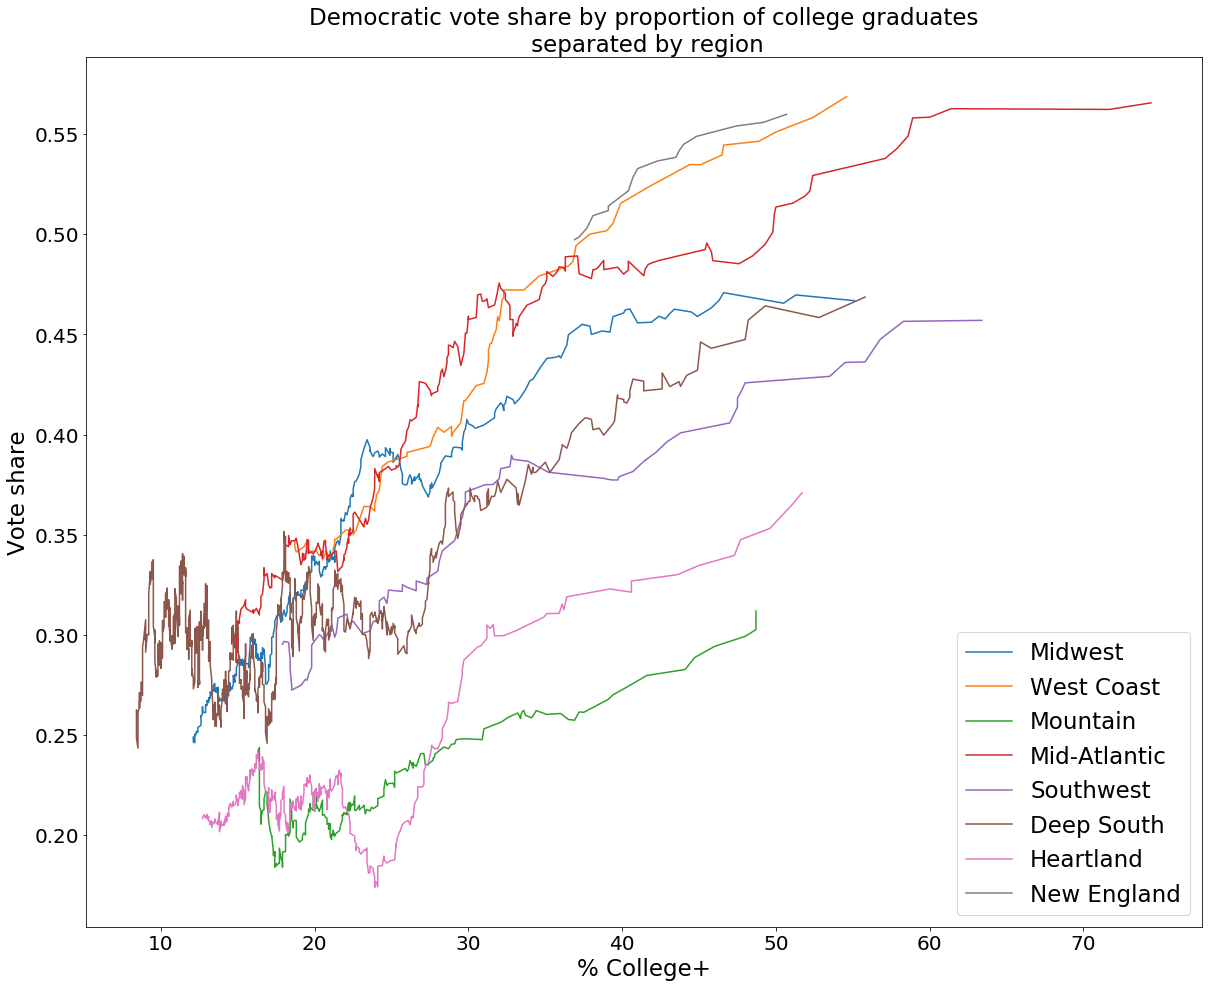

In [147]:
college_by_reg = {}
plt.figure(figsize=(20, 16))
for region in set(region_dict.values()) - {np.nan, 'Hawaii', 'Alaska'}:
    college_by_reg[region] = (full_1216_df[full_1216_df['region'] == region].\
                sort_values(by = '% College+')['% College+'],\
                    pd.rolling_mean(full_1216_df\
                        [full_1216_df['region'] == region].\
                            sort_values(by = '% College+')['% Dem 16'], 50))
for region in set(region_dict.values()) - {np.nan, 'Hawaii', 'Alaska'}:
    plt.plot(college_by_reg[region][0], college_by_reg[region][1], label = region)
plt.legend(loc = 'lower right', fontsize = 23)
plt.xlabel('% College+', fontsize = 23)
plt.ylabel('Vote share', fontsize = 23)
plt.title('Democratic vote share by proportion of college graduates\n separated by region', fontsize = 23)
plt.legend(loc = 'lower right', fontsize = 23)
plt.gca().tick_params('both', labelsize = 20)
# plt.gca().set_xscale('log')
plt.show()

/Users/ryan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=25,center=False).mean()
  after removing the cwd from sys.path.


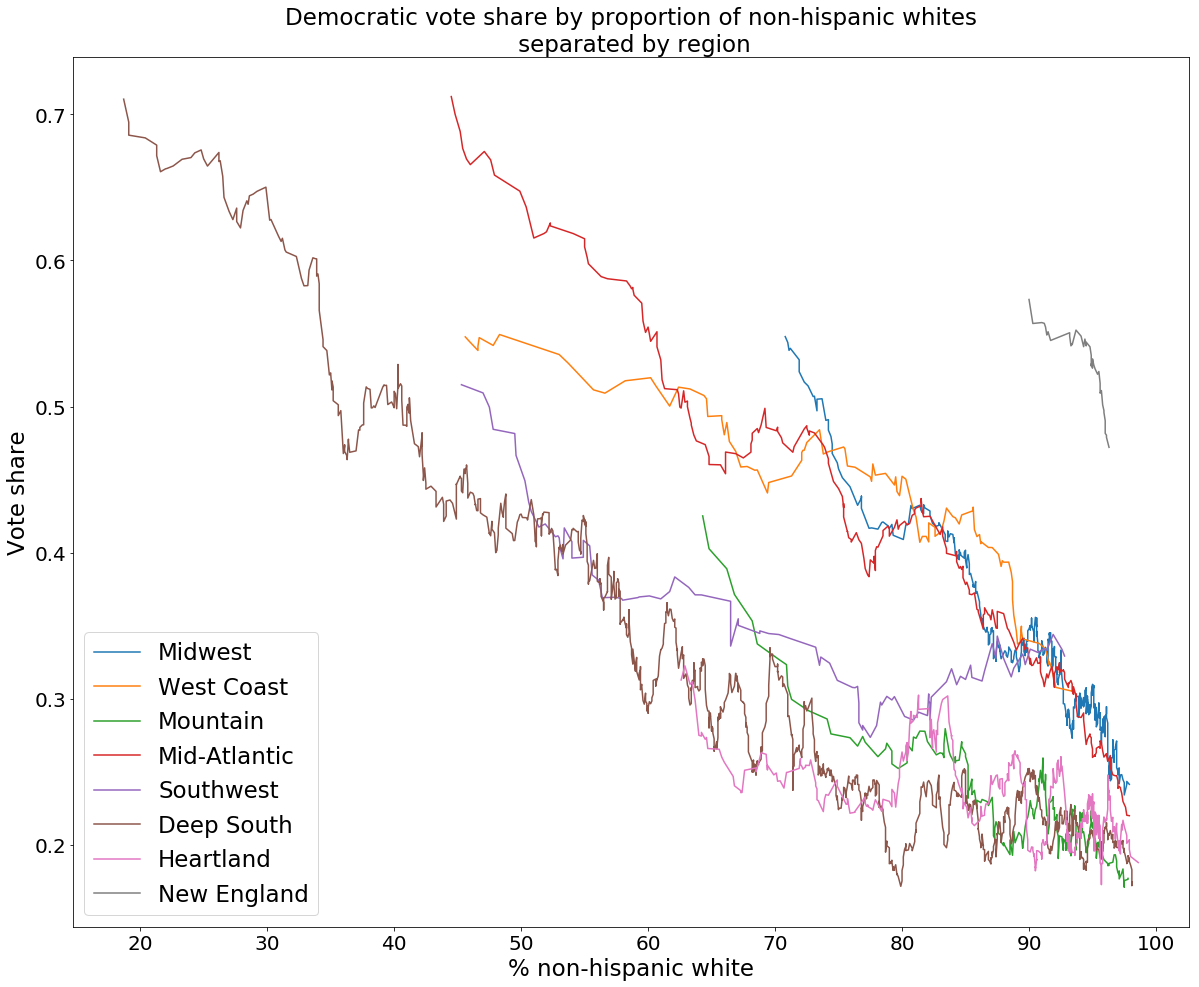

In [149]:
white_by_reg = {}
plt.figure(figsize=(20, 16))
for region in set(region_dict.values()) - {np.nan, 'Hawaii', 'Alaska'}:
    white_by_reg[region] = (full_1216_df[full_1216_df['region'] == region].\
            sort_values(by = '% non-hisp. white')['% non-hisp. white'],\
            pd.rolling_mean(full_1216_df\
            [full_1216_df['region'] == region].\
            sort_values(by = '% non-hisp. white')['% Dem 16'], 25))
for region in set(region_dict.values()) - {np.nan, 'Hawaii', 'Alaska'}:
    plt.plot(white_by_reg[region][0], white_by_reg[region][1], \
                                                     label = region)
#plt.gca().set_xscale('log')
plt.xlabel('% non-hispanic white', fontsize = 23)
plt.ylabel('Vote share', fontsize = 23)
plt.title('Democratic vote share by proportion of non-hispanic whites\n separated by region', fontsize = 23)
plt.legend(loc = 'lower left', fontsize = 23)
plt.gca().tick_params('both', labelsize = 20)
plt.show()

It is striking how much of an outlier New England is here. It is the only region where the median county voted for Clinton, despite a racial make-up that is generally unfavorable to Democrats.

/Users/ryan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=25,center=False).mean()
  after removing the cwd from sys.path.


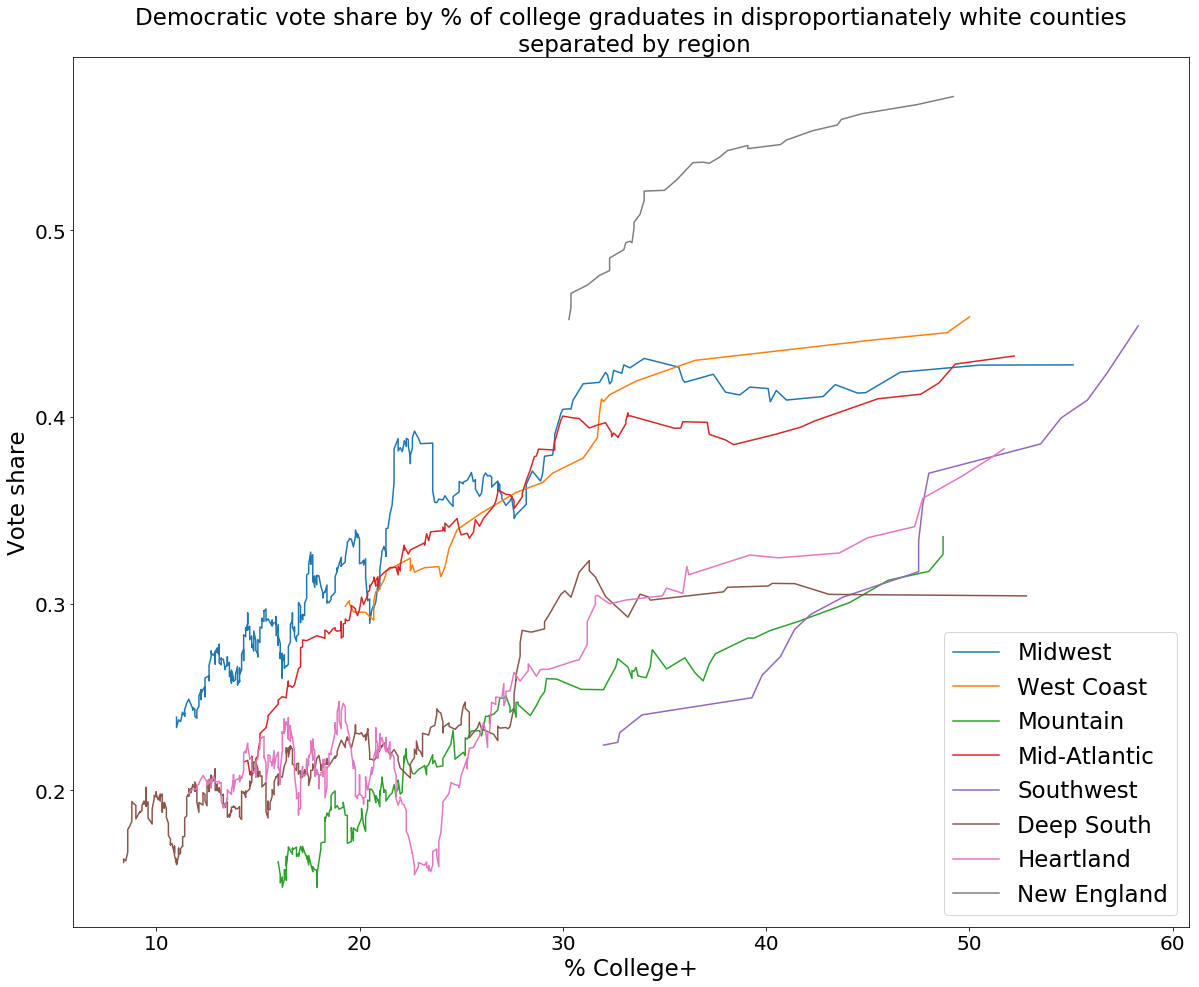

In [154]:
whites_college_by_reg = {}
plt.figure(figsize=(20, 16))
for region in set(region_dict.values()) - {np.nan, 'Hawaii', 'Alaska'}:
    college_by_reg[region] = (full_1216_df[(full_1216_df['region'] == region)\
                & (full_1216_df['% non-hisp. white'] > 77)].\
                sort_values(by = '% College+')['% College+'],\
                    pd.rolling_mean(full_1216_df\
                    [(full_1216_df['region'] == region) & \
                     (full_1216_df['% non-hisp. white'] > 77)].\
                    sort_values(by = '% College+')['% Dem 16'], 25))
for region in set(region_dict.values()) - {np.nan, 'Hawaii', 'Alaska'}:
    plt.plot(college_by_reg[region][0], college_by_reg[region][1], label = region)
# plt.gca().set_xscale('log')
plt.xlabel('% College+', fontsize = 23)
plt.ylabel('Vote share', fontsize = 23)
plt.title('Democratic vote share by % of college graduates in disproportianately white counties\n separated by region', fontsize = 23)
plt.legend(loc = 'lower right', fontsize = 23)
plt.gca().tick_params('both', labelsize = 20)
plt.show()

/Users/ryan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=25,center=False).mean()
  after removing the cwd from sys.path.


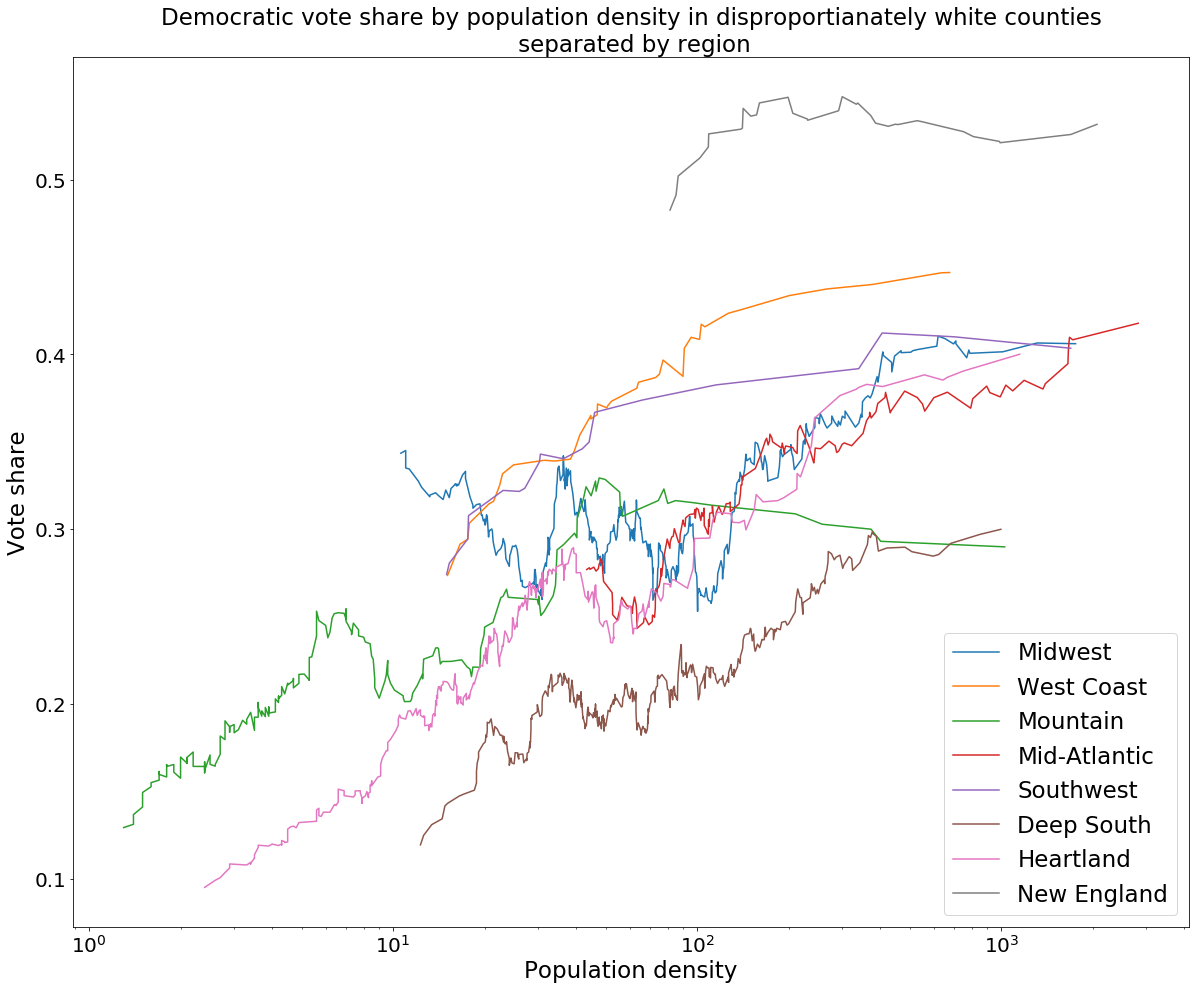

In [156]:
whites_density_by_reg = {}
plt.figure(figsize=(20, 16))
for region in set(region_dict.values()) - {np.nan, 'Hawaii', 'Alaska'}:
    college_by_reg[region] = (full_1216_df[(full_1216_df['region'] == region)\
                & (full_1216_df['% non-hisp. white'] > 77)].\
                sort_values(by = 'density')['density'],\
                    pd.rolling_mean(full_1216_df\
                    [(full_1216_df['region'] == region) & \
                     (full_1216_df['% non-hisp. white'] > 77)].\
                    sort_values(by = 'density')['% Dem 16'], 25))
for region in set(region_dict.values()) - {np.nan, 'Hawaii', 'Alaska'}:
    plt.plot(college_by_reg[region][0], college_by_reg[region][1], label = region)
plt.legend(loc = 'lower right', fontsize = 23)
plt.gca().set_xscale('log')
plt.xlabel('Population density', fontsize = 23)
plt.ylabel('Vote share', fontsize = 23)
plt.title('Democratic vote share by population density in disproportianately white counties\n separated by region', fontsize = 23)
plt.legend(loc = 'lower right', fontsize = 23)
plt.gca().tick_params('both', labelsize = 20)
plt.show()